# Data Scientist Open Positions by Metro Area

In [7]:
# Imports Dependencies
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

### Define Function to Calculate Distance Between Two Sets of Latitude & Longitude

In [8]:
def gc_dist_np(lat1, lon1, lat2, lon2):
    """
    Using the Haversine Formula and presuming a spherical Earth with radius R this function  
        calculates the great circle distance (elevation not taken into account) between two points.

    Note: this method is not extremely accurate at short distances (<10km)
    
    Attributes:
        lat1 - Latitude of city 1
        lon1 - Longitude of city 1
        lat2 - Latitude of city 2
        lon2 - Longitude of city 2
        
    Returns:
        Distance in miles
    """
    R = 3956 # Approximate radius of the earth in statute miles
    
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a)) # great circle distance in radians

    return R * c

### Read Raw Data .csv's into 2 Dataframes

In [9]:
openings_df = pd.read_csv('openings_by_city_lat_long.csv',
                            sep=',',
                            usecols=['city', 'openings', 'lat', 'long'],
                           )
metro_area_df = pd.read_csv('metro_area_pop_data.csv',
                              sep=',',
                              header=None,
                              usecols=[1, 2, 6, 7],
                              names=['metro', 'population', 'lat', 'lon']
                             )

In [10]:
openings_df.head()

,city,openings,lat,long
0,"New York, NY",169,40.712775,-74.005973
1,"Boston, MA",158,42.360083,-71.058880
2,"Charlotte, NC",106,35.227087,-80.843127
3,"Philadelphia, PA",102,39.952584,-75.165222
4,"Irving, TX",101,32.814018,-96.948894


In [11]:
metro_area_df.head()

,metro,population,lat,lon
0,"New York-Newark-Jersey City, NY-NJ-PA",19949502,40.712784,-74.005941
1,"Los Angeles-Long Beach-Anaheim, CA",13131431,34.052234,-118.243685
2,"Chicago-Naperville-Elgin, IL-IN-WI",9537289,41.878114,-87.629798
3,"Dallas-Fort Worth-Arlington, TX",6810913,32.780140,-96.800451
4,"Houston-The Woodlands-Sugar Land, TX",6313158,29.760193,-95.369390


### Clean, Organize and Prepare Data for Processing

In [12]:
metro_area_df = metro_area_df[['metro', 'population', 'lat', 'lon']]

In [13]:
metro_area_df.head()

,metro,population,lat,lon
0,"New York-Newark-Jersey City, NY-NJ-PA",19949502,40.712784,-74.005941
1,"Los Angeles-Long Beach-Anaheim, CA",13131431,34.052234,-118.243685
2,"Chicago-Naperville-Elgin, IL-IN-WI",9537289,41.878114,-87.629798
3,"Dallas-Fort Worth-Arlington, TX",6810913,32.780140,-96.800451
4,"Houston-The Woodlands-Sugar Land, TX",6313158,29.760193,-95.369390


In [14]:
openings_df.rename(columns={"long": "lon"}, inplace=True)

In [15]:
city_state_df = openings_df['city'].str.split(", ", n = 1, expand = True)
openings_df['city'] = city_state_df[0]
openings_df['state'] = city_state_df[1]

In [16]:
openings_df = openings_df[['city', 'state', 'openings', 'lat', 'lon']]

In [17]:
openings_df.head()

,city,state,openings,lat,lon
0,New York,NY,169,40.712775,-74.005973
1,Boston,MA,158,42.360083,-71.058880
2,Charlotte,NC,106,35.227087,-80.843127
3,Philadelphia,PA,102,39.952584,-75.165222
4,Irving,TX,101,32.814018,-96.948894


### Create New Dataframe with Final Results

In [18]:
# Initialize dict to hold openings be metro area data
openings_by_metro_dict = {}
for i_pop, r_pop in metro_area_df.iterrows():
    metro_cnt = 0
    for i_open, r_open in openings_df.iterrows():
        # Metro Areas with fewer than 500,000 inhibitants are disregarded
        if r_pop['population'] < 500000:
            continue
        else:
            # Use Haversine Formula to calculate distance from metro area to city
            dist = gc_dist_np(r_pop['lat'], r_pop['lon'], r_open['lat'], r_open['lon'])
            # If distance from metro area to city is greater than 50 miles, disregard city
            if dist <= 50:
                # Maintain an accumulator of openings per metro area
                metro_cnt += int(r_open['openings'])
                openings_by_metro_dict[r_pop['metro']] = metro_cnt

In [19]:
openings_by_metro_area_df = pd.DataFrame.from_dict(openings_by_metro_dict, orient='index',
...                        columns=['openings'])

In [43]:
# final_openings_df = openings_by_metro_area_df.sort_values('openings', ascending=False)
top_ten_openings_df = openings_by_metro_area_df.nlargest(10, 'openings')
top_ten_openings_df

,openings
"New York-Newark-Jersey City, NY-NJ-PA",209
"Worcester, MA-CT",187
"Boston-Cambridge-Newton, MA-NH",180
"Providence-Warwick, RI-MA",179
"San Francisco-Oakland-Hayward, CA",172
"San Jose-Sunnyvale-Santa Clara, CA",170
"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",140
"Allentown-Bethlehem-Easton, PA-NJ",138
"Dallas-Fort Worth-Arlington, TX",120
"Charlotte-Concord-Gastonia, NC-SC",106


### Plot and Save Horizontal Bar Chart

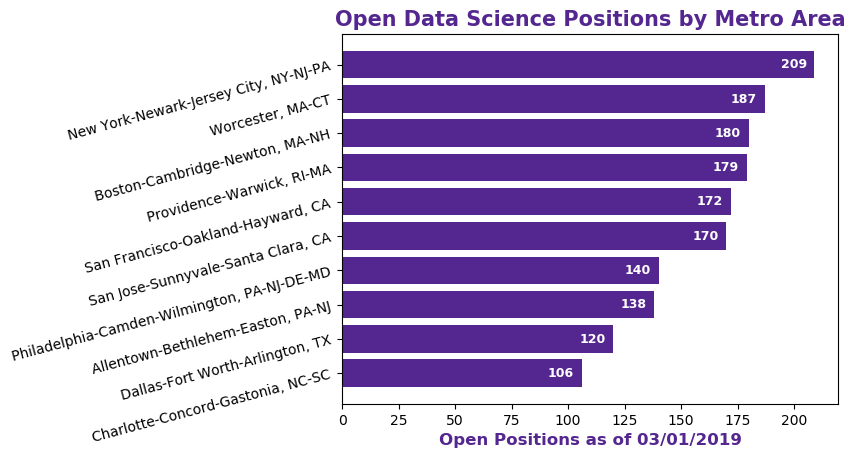

In [140]:
# Organize and propery arrange dataframes
headers = top_ten_openings_df.index.tolist()
headers.reverse()
openings = top_ten_openings_df.openings.tolist()
openings.reverse()
y_pos = np.arange(len(objects))

# Plot bar chart 
plt.title('Open Data Science Positions by Metro Area',
          fontsize=15,
          fontweight='bold',
          color='#54268F'
         )
plt.xlabel('Open Positions as of 03/01/2019',
          fontsize=12,
          fontweight='bold',
          color='#54268F'
         )
plt.barh(y_pos, openings,
         align='center',
         color='#54268F'
        )
plt.yticks(y_pos, headers,
           rotation = '15',
          )

# Plot openings value in each bar
for i in range(len(y_pos)):
    plt.text(x = openings[i] - 15.0,
             y = y_pos[i] - 0.1,
             s = openings[i],
             size = 9,
             weight='bold',
             color = 'w')
# Save chart
plt.savefig('ds_openings_by_metro_area-barh-v2.png')

# Plot chart
plt.show()